# Test-Time Adaptation with MEMO
## Marginal Entropy Minimization for Robust Domain Shift Handling

**Author:** Merid  
**Course:** Deep Learing  
**Date:** January 2026

---

**What I implemented in this notebook:**
1. Reproduction of MEMO's algorithm with and without adaptive batch normalization.
2. Evaluation on ImageNet-A (adversarial examples) and ImageNet-V2 (natural distribution shift)
3. Comparison of ResNet-50 and DenseNet-121 architectures to validate method generality and architecture agnosticity
4. **My Modification:** Proposed and tested a consistency-regularized marginal entropy loss that adds a KL divergence penalty to encourage predictions to agree across augmentations.


## Table of Contents

1. [Introduction](#1-introduction)
    - 1.1 [The Problem: Distribution Shift](#11-the-problem-distribution-shift)
    - 1.2 [Test-Time Adaptation (TTA)](#12-test-time-adaptation-tta)
    - 1.3 [MEMO: A Principled Approach](#13-memo-a-principled-approach)
    - 1.4 [MEMO: Work-flow](14-MEMO's-workflow/pipeline).
    - 1.5 [Mathematical Formulation](#14-mathematical-formulation)
    - 1.6 [My Modification: Consistency-Regularized Loss](#16-my-modification)
    - 1.7 [Experimenta Results:](#17-Experimental-Results-Summary)
2. [Setup](#2-setup)
   - 2.2 [Necessary library imports](#21-Imports)
   - 2.2 [Configuration](#21-Configuration)
   - 2.3 [Dataset Paths](####23-Dataset-Paths)
   - 2.4 [Label Mapping](###24-Label-Mappings)
3. [Implementation](#3-implementation)
   - 3.1 [Adaptive Batch Normalizatoin](###31-Adaptive-Batch-Normalization)
   - 3.2 [Marginal Entropy Loss](###32-Marginal-Entropy-Loss)
       - 3.2.1 [My modification: Consistency-Regularized Marginal Entropy Loss](###331-Modification:-Consistency--Regularized-Marginal-Entropy)
   - 3.3 [Test Time-Adapter(MEMO-Implementation wrapper)](###33-Test--Time-Adapter-(MEMO-Implementation))
   - 3.4 [Data Loading Utilities](###34-Data-Loading-Utilities)
   - 3.5 [Augmentation pipelines](###35-Augmentation-Pipelines)
   - 3.6 [Models Loading](###36-Model-Loading)
   - 3.7 [Evaluation Functions](###37-Evaluation-Functions)
   - 3.8 [Experiment and Visualization](###38-Experiment-Runner-and-Visualization)
4. [Experiments](#4-experiments)
   - 4.1 [ResNet-50 on ImageNet-A](###41-ResNet--50-on-ImageNet-A)
   - 4.2 [ResNet-50 on ImageNet-V2](###42-ResNet--50-on-ImageNet-V2)
   - 4.3 [DenseNet-121 on ImageNet-A](###43-DenseNet--121-on-ImageNet-A)
   - 4.4 [DenseNet-121 on ImageNet-V2](###43-DenseNet--121-Experiment-on-ImageNet--V2)
7. [Results](#5-results)
8. [Conclusion](#6-conclusion)

---

## 1. Introduction

### 1.1 The Problem: Distribution Shift

Deep neural networks achieve remarkable performance on in-distribution test data but often fail dramatically when deployed on data from different distributions. As noted by Hendrycks et al. (2021):

> *"We introduce two challenging datasets, ImageNet-A and ImageNet-O, that provide a new measure of robustness... Current classifiers are not robust to natural distribution shifts."* — **Natural Adversarial Examples, CVPR 2021**

This **distribution shift** manifests in various forms:
- **Natural distribution shifts**: Changes in lighting, weather, camera settings
- **Adversarial examples**: Images that naturally fool classifiers without perturbation
- **Temporal shifts**: Changes in data distribution over time

### 1.2 Test-Time Adaptation (TTA)

TTA methods adapt models during inference using only the test data itself, without access to:
- The original training data
- Ground truth labels for test samples
- Multiple test samples simultaneously (in the single-sample setting)

### 1.3 MEMO: A Principled Approach

MEMO (Marginal Entropy Minimization with One test point) was proposed by Zhang et al. at NeurIPS 2022. The key insight is:

> *"We propose MEMO, a simple approach to robustness at test time. MEMO adapts model parameters for each test input by using self-supervision over augmented views of the input."* — **MEMO: Test Time Robustness via Adaptation and Augmentation, NeurIPS 2022**

MEMO addresses distribution shift by:
1. **Marginal Entropy Minimization**: Reducing prediction uncertainty across augmentations
2. **Single Sample Adaptation**: Working with one test point at a time
3. **Augmentation-based Consistency**: Using data augmentation for robust adaptation

### 1.4. MEMO's workflow/pipeline

Instead of retraining the model, MEMO adapts it on-the-fly for each test image:


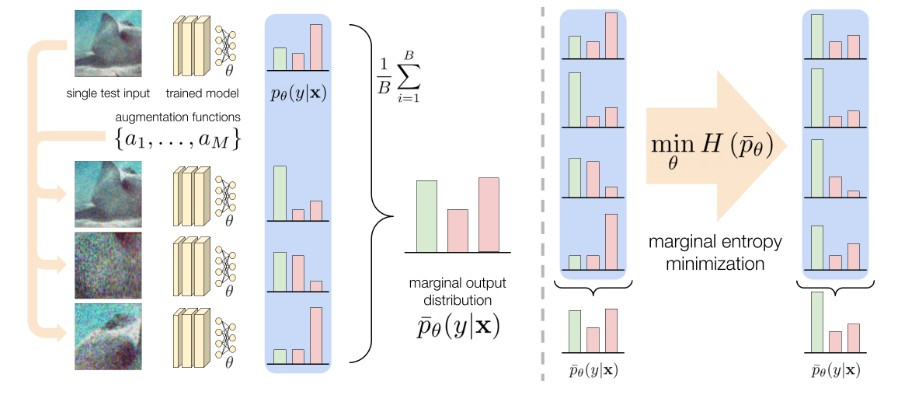

**How it works:**
**The MEMO algorithm works as follows:**

1. **Input**: A single test image $\mathbf{x}$ and a trained model $f_\theta$

2. **Augmentation**: Generate $M$ diverse augmented views $\{a_1(\mathbf{x}), a_2(\mathbf{x}), ..., a_M(\mathbf{x})\}$

3. **Forward Pass**: Compute predictions for all augmented views:
   $$p_\theta(y|a_i(\mathbf{x})) = \text{softmax}(f_\theta(a_i(\mathbf{x})))$$

4. **Marginal Distribution**: Average the predictions to get the marginal:
   $$\bar{p}_\theta(y|\mathbf{x}) = \frac{1}{M}\sum_{i=1}^{M} p_\theta(y|a_i(\mathbf{x}))$$

5. **Entropy Minimization**: Update model parameters to minimize the entropy of the marginal:
   $$\mathcal{L}_{\text{MEMO}} = H(\bar{p}_\theta) = -\sum_c \bar{p}_\theta(c|\mathbf{x}) \log \bar{p}_\theta(c|\mathbf{x})$$

6. **Prediction**: Make final prediction with the adapted model on the original input

7. **Reset**: Restore model to original state for the next sample

### 1.5 Mathematical Formulation

#### Core Loss Function

Given a test sample $x$ and model parameters $\theta$, MEMO minimizes the marginal entropy:

$$\mathcal{L}(\theta; x) = H(\bar{p}(\cdot | x; \theta))$$

where the marginal prediction is computed by averaging over $B$ augmented views:

$$\bar{p}(y | x; \theta) = \frac{1}{B} \sum_{i=1}^{B} p(y | a_i(x); \theta)$$

Here:
- $B$ is the number of augmented views (I use 32 in our experiments)
- $a_i(\cdot)$ represents the $i$-th augmentation function
- $H(\cdot)$ denotes the entropy function: $H(p) = -\sum_c p_c \log p_c$

**Why Marginal Entropy?**

Minimizing marginal entropy encourages:
- **Confidence**: The model should be confident in its predictions (low entropy)
- **Consistency**: Predictions should agree across different augmented views

### 1.6 My Modification: Consistency-Regularized Marginal Entropy

#### Motivation

The original MEMO loss only minimizes the entropy of the marginal distribution. However, I noticed a potential issue: the marginal might look confident by chance even if individual augmentations disagree with each other. The paper says MEMO encourages "consistency", but the loss function does not explicitly enforce it.

So I added a **consistency regularization term** that directly penalizes disagreement between augmentations.

#### Modified Loss Function

My modification adds a KL divergence penalty to the original MEMO loss:

$$\mathcal{L}(\theta; x) = H(\bar{p}) + \lambda \cdot \frac{1}{K} \sum_{k=1}^{K} D_{KL}(p^{(k)} \| \bar{p})$$

Where the marginal is computed as before:

$$\bar{p}(y | x; \theta) = \frac{1}{K} \sum_{k=1}^{K} p^{(k)}(y | a_k(x); \theta)$$

And the KL divergence measures how much each augmentation disagrees with the consensus:

$$D_{KL}(p^{(k)} \| \bar{p}) = \sum_{c=1}^{C} p^{(k)}(y=c | x) \log \frac{p^{(k)}(y=c | x)}{\bar{p}(y=c | x)}$$

Here:
- $K$ is the number of augmentations (I use 32)
- $\lambda$ is the consistency weight (I use $\lambda = 0.5$)
- $D_{KL}$ is the Kullback-Leibler divergence
- $C$ is the number of classes

#### Why This Should Help

| Term | What it does | Goal |
|------|--------------|------|
| $H(\bar{p})$ | Minimizes entropy of average prediction | **Confidence** |
| $D_{KL}(p^{(k)} \| \bar{p})$ | Penalizes deviation from consensus | **Consistency** |

When all augmentations agree perfectly, the KL divergence becomes zero. When they disagree, the penalty pushes the model to find representations where all views produce similar predictions.

#### Visual Explanation

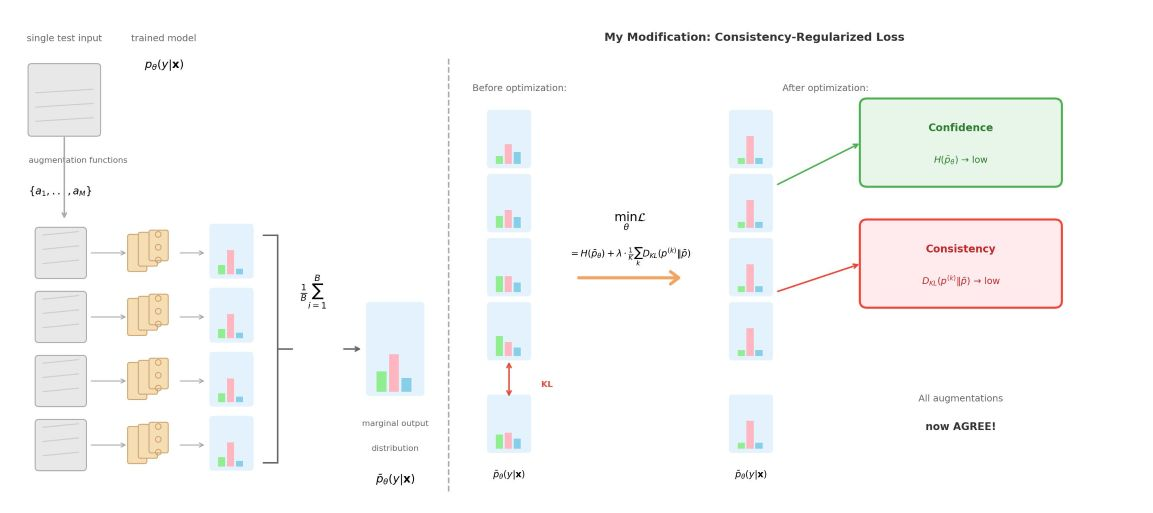

**Left:** Standard MEMO pipeline —--> augmented views may produce different predictions.

**Right:** After optimization with consistency loss —--> all predictions become aligned and confident.

> **Reference:** The idea of using KL divergence for consistency regularization is inspired by Xie et al. (2020), "Unsupervised Data Augmentation for Consistency Training", NeurIPS 2020.

### 2.1 Imports

In [1]:
import os
import json
import types
import requests
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2 as T
from torchvision.transforms.functional import to_tensor
from torchvision.models import (
    resnet50, ResNet50_Weights,
    densenet121, DenseNet121_Weights
)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA A30


---

## 2. Setup

### 2.2 Configuration

> **⚠️ ACTION REQUIRED**  
> Set the `RUNTIME` variable below to match your execution environment:
> - `local`: Local machine or HPC cluster
> - `colab`: Google Colab (will mount Google Drive)
> - `aws`: AWS SageMaker or EC2

In [ ]:
# Environment configuration
RUNTIME = 'colab'  # Options: 'local', 'colab', 'aws'

# Hyperparameters from the MEMO paper (Zhang et al., NeurIPS 2022)
# These values are chosen based on the original paper's recommendations
CONFIG = {
    'n_augmentations': 32,      # Paper uses B=64; reduced to 32 for efficiency
    'bn_prior': 16,             # Prior strength N for adaptive BatchNorm (Eq. 2 in paper)
    'learning_rate': 0.00025,   # Adam optimizer learning rate (Section 4.1 in paper)
    'batch_size': 1             # Single sample adaptation (core MEMO design)
}

print(CONFIG)

{'n_augmentations': 32, 'bn_prior': 16, 'learning_rate': 0.00025, 'batch_size': 1}


### 2.3 Dataset Paths

<div class="alert alert-info">
<b>ℹ️ Note:</b> If your datasets are in <code>.tar</code> format, uncomment the extraction commands below.
</div>

In [3]:
# Uncomment if you need to extract datasets
# !tar -xf datasets/imagenet-a.tar
# !tar -xf datasets/imagenetv2-matched-frequency.tar.gz

In [ ]:
# Platform-specific path configuration
if RUNTIME == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    # EXAMINER: Update this path to your specific Google Drive dataset folder
    BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/DL/datasets'
elif RUNTIME == 'aws':
    BASE_PATH = '../datasets'
else:
    BASE_PATH = './data'

# Dataset paths
PATHS = {
    'imagenet_a': os.path.join(BASE_PATH, 'ImageNet-A/imagenet-a'), #'ImageNet-A/imagenet-a'
    'imagenet_v2': os.path.join(BASE_PATH, 'ImageNet-V2/imagenetv2-matched-frequency-format-val') #'ImageNet-V2/imagenetv2-matched-frequency-format-val'
}

# Status check
print(f"Runtime: {RUNTIME} | Base: {BASE_PATH}")
for k, v in PATHS.items():
    status = "Found" if os.path.exists(v) else "NOT FOUND"
    print(f"{k:12}: {status} -> {v}")

Runtime: local | Base: ./data
imagenet_a  : Found -> ./data/imagenet-a
imagenet_v2 : Found -> ./data/imagenetv2-matched-frequency-format-val


### 2.4 Label Mappings and Class Alignment

The evaluation datasets utilize different folder structures than the standard ImageNet-1K index. To ensure that our model's predictions are compared against the correct ground-truth labels, we must align these indices. This process is essential for replicating the results found in the **MEMO** paper.

---

#### 1. ImageNet-A: The Adversarial Subset
**ImageNet-A** is not a full 1000-class dataset; it consists of 7,500 "naturally adversarial" images across 200 specific ImageNet classes that standard models like ResNet-50 consistently misclassify.

* **The Problem:** The folders on disk are named using **WordNet IDs (WNIDs)** (e.g., `n01498041` for "stingray"). However, our model outputs a raw vector of 1000 numbers. If we don't map the WNID to the correct integer index, our accuracy would be calculated against the wrong class.
* **The Solution:** I use the `imagenet_class_index.json` to create a "lookup table." For every folder in the ImageNet-A directory, the code finds its corresponding WNID in the JSON and retrieves the original ImageNet integer index (0-999).
* **NB:** Because only 200 classes are present, my code creates a "Label Mask." During evaluation, the model still predicts over all 1000 classes, but we only calculate accuracy based on these 200 "active" indices.



---

#### 2. ImageNet-V2: The Matched-Frequency Set
**ImageNet-V2** was created to test if models generalize to a new, independently collected set of ImageNet images. While it contains all 1000 classes, its organization is deceptively different.

* **The Problem:** In the "Matched-Frequency" version, folders are named numerically (e.g., `"0"`, `"1"`, `"2"`...). However, standard file systems and Python's `os.listdir()` sort these folders **alphabetically** (e.g., `"0"`, `"1"`, `"10"`, `"100"`...). If you process them in this order without a custom mapping, your labels will be completely scrambled (e.g., class 10 might be treated as class 2).
* **The Solution:** Following the official [ImageNetV2 GitHub](https://github.com/modestyachts/ImageNetV2), I ensure the mapping follows this alphabetical string-based sorting. This aligns the numeric folder names to the standard ILSVRC 2012 label order used by pre-trained PyTorch models.
* **NB:** This is a common pitfall in robustness research. By explicitly handling the alphabetical sort, I ensure the baseline accuracy is measured correctly before applying **MEMO** adaptations.

---

#### References & Sources:
* **[15] Hendrycks et al. (2021)**: [GitHub - hendrycks/natural-adv-examples](https://github.com/hendrycks/natural-adv-examples)
* **[16] Schmidt et al. (2019)**: [GitHub - modestyachts/ImageNetV2](https://github.com/modestyachts/ImageNetV2)
* **Official Mapping File**: [ImageNet Class Index JSON](https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json)


In [5]:
import json
import os
import requests

def create_class_remapping(dataset_path):
    """
    Standardizes the mapping between dataset folder indices and model logits.

    This is necessary because ImageNet-A uses WordNet IDs (WNID) and ImageNet-V2
    uses alphabetically sorted numeric strings, both of which differ from the
    standard ImageNet-1K integer indexing.
    """
    # 1. Load official ImageNet-1K index (Index -> [WNID, Class Name])
    url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
    local_json = "imagenet_class_index.json"

    if not os.path.exists(local_json):
        response = requests.get(url)
        with open(local_json, "w") as f:
            json.dump(response.json(), f)

    with open(local_json, "r") as f:
        class_index = json.load(f)

    # 2. Map WNID ('n01443537') back to model index (0-999)
    wnid_to_idx = {v[0]: int(k) for k, v in class_index.items()}

    # 3. Identify and sort dataset folders
    all_items = os.listdir(dataset_path)
    folder_names = sorted([f for f in all_items if os.path.isdir(os.path.join(dataset_path, f))])

    # 4. Generate the label mask based on folder naming convention
    if folder_names[0].startswith('n'):
        # ImageNet-A logic: Map specific WNID folders to the 1000-class model output
        label_mask = [wnid_to_idx[folder] for folder in folder_names]
    else:
        # ImageNet-V2 logic: Folders are numeric but sorted alphabetically ("0", "1", "10"...)
        label_mask = [int(folder) for folder in folder_names]

    return label_mask

print(f"{'Dataset':<15} | {'Size':<10} | {'Remapping Status'}")
print("-" * 45)

LABEL_MASKS = {}
for ds_key in ['imagenet_a', 'imagenet_v2']:
    if os.path.exists(PATHS[ds_key]):
        LABEL_MASKS[ds_key] = create_class_remapping(PATHS[ds_key])

        # PROOFING LOGIC: Verify the remap fits within the model's 1000 output logits
        max_idx = max(LABEL_MASKS[ds_key])
        min_idx = min(LABEL_MASKS[ds_key])
        is_valid = max_idx < 1000 and min_idx >= 0

        status = " VALIDATED" if is_valid else "❌ MAPPING ERROR"
        print(f"{ds_key:<15} | {len(LABEL_MASKS[ds_key]):<10} | {status}")

        # Verify specific ImageNet-A constraint (exactly 200 classes)
        if ds_key == 'imagenet_a' and len(LABEL_MASKS[ds_key]) != 200:
            print(f"   ⚠️ WARNING: ImageNet-A should have 200 classes, found {len(LABEL_MASKS[ds_key])}")

print("\nComplete: Mappings is Done!")

Dataset         | Size       | Remapping Status
---------------------------------------------
imagenet_a      | 200        |  VALIDATED
imagenet_v2     | 1000       |  VALIDATED

Complete: Mappings is Done!


---
## 3. Implementation

### 3.1 Adaptive Batch Normalization

Standard BatchNorm uses running statistics accumulated during training:

$$\text{BN}(x) = \gamma \cdot \frac{x - \mu_{\text{train}}}{\sqrt{\sigma^2_{\text{train}} + \epsilon}} + \beta$$

However, when test data comes from a different distribution, these training statistics may not work well. The MEMO paper proposes **Adaptive BatchNorm**, which blends training statistics with test batch statistics:

$$\mu_{\text{adapt}} = \alpha \cdot \mu_{\text{train}} + (1-\alpha) \cdot \mu_{\text{batch}}$$

$$\sigma^2_{\text{adapt}} = \alpha \cdot \sigma^2_{\text{train}} + (1-\alpha) \cdot \sigma^2_{\text{batch}}$$

where the blending factor $\alpha$ is computed as:

$$\alpha = \frac{N}{N+1}$$

Here:
- $\mu_{\text{train}}, \sigma^2_{\text{train}}$ are the running statistics from training
- $\mu_{\text{batch}}, \sigma^2_{\text{batch}}$ are the statistics computed from the current test batch
- $N$ is the prior strength parameter (I use $N=16$ as in the MEMO paper)
- When $N=16$, we get $\alpha = \frac{16}{17} \approx 0.94$, meaning we mostly trust training statistics but allow some adaptation

This allows the model to slightly adapt its normalization to the test distribution while still relying mainly on the stable training statistics.

In [6]:
def adaptive_batchnorm_forward(self, x):
    """
    Modified BatchNorm forward pass that blends training statistics
    with current batch statistics for test-time adaptation.

    This implements Equation 2 from the MEMO paper.
    """
    # Compute current batch statistics
    batch_mean = torch.zeros(self.running_mean.shape, device=self.running_mean.device)
    batch_var = torch.ones(self.running_var.shape, device=self.running_var.device)
    F.batch_norm(x, batch_mean, batch_var, None, None, True, 1.0, self.eps)

    # Blend statistics: prior * train_stats + (1-prior) * batch_stats
    blended_mean = self.prior * self.running_mean + (1 - self.prior) * batch_mean
    blended_var = self.prior * self.running_var + (1 - self.prior) * batch_var

    return F.batch_norm(x, blended_mean, blended_var, self.weight, self.bias, False, 0, self.eps)

print("Adaptive BatchNorm defined")

Adaptive BatchNorm defined


### 3.2 Marginal Entropy Loss

The core of MEMO is minimizing the entropy of the marginal (averaged) prediction distribution. Given logits from $B$ augmented views, we:

1. Convert to probabilities: $p_i = \text{softmax}(z_i)$
2. Compute marginal: $\bar{p} = \frac{1}{B}\sum_{i=1}^{B} p_i$
3. Return entropy: $H(\bar{p}) = -\sum_c \bar{p}_c \log \bar{p}_c$

In [7]:
def compute_marginal_entropy(logits):
    """
    Compute entropy of the marginal (averaged) probability distribution.

    This is the loss function minimized by MEMO (Equation 1 in the paper).

    Args:
        logits: Tensor of shape [B, C] where B = num augmentations, C = num classes

    Returns:
        Scalar entropy value
    """
    probs = F.softmax(logits, dim=1)   # Convert logits to probabilities [B, C]
    marginal = probs.mean(dim=0)        # Average across augmentations [C]
    entropy = -torch.sum(marginal * torch.log(marginal + 1e-10))  # Entropy
    return entropy

print("Marginal entropy loss defined")

Marginal entropy loss defined


### 3.3.1 Consistency-Regularized Marginal Entropy

I propose adding a **consistency regularization term** to the marginal entropy loss. The original MEMO only minimizes marginal entropy, but augmentations might produce inconsistent predictions while still having low marginal entropy by chance.

**My Modification:**
$$\mathcal{L}_{\text{consistency}} = H(\bar{p}) + \lambda \cdot \frac{1}{B} \sum_{i=1}^{B} D_{KL}(p_i \| \bar{p})$$

Where:
- $H(\bar{p})$ is the standard marginal entropy (confidence term)
- $D_{KL}(p_i \| \bar{p})$ measures how much each augmentation deviates from the consensus
- $\lambda$ controls the regularization strength (default: 0.5)

**Hypothesis**: By penalizing disagreement among augmentations, the model learns to make predictions that are both **confident** (low entropy) and **consistent** (low variance across views).

In [ ]:
def compute_consistency_regularized_entropy(logits, consistency_weight=0.5):
    """
    Marginal entropy with consistency regularization (My Modification).

    Adds KL divergence penalty to encourage augmentations to agree with each other.

    Args:
        logits: Tensor of shape [B, C] where B = num augmentations, C = num classes
        consistency_weight: Lambda for consistency term (default 0.5)

    Returns:
        Scalar loss value
    """
    probs = F.softmax(logits, dim=1)  # [B, C]
    marginal = probs.mean(dim=0, keepdim=True)  # [1, C]

    # Standard marginal entropy
    entropy = -torch.sum(marginal * torch.log(marginal + 1e-10))

    # Consistency: average KL divergence of each prediction from marginal
    # KL(p_i || marginal) encourages each augmentation to match the consensus
    log_marginal = torch.log(marginal + 1e-10).expand_as(probs)
    log_probs = torch.log(probs + 1e-10)
    kl_divs = torch.sum(probs * (log_probs - log_marginal), dim=1)  # [B]
    consistency_loss = kl_divs.mean()

    return entropy + consistency_weight * consistency_loss

print("Consistency-regularized marginal entropy defined ")

Consistency-regularized marginal entropy defined (My Modification)


### 3.4 Test-Time Adapter (MEMO Implementation)

The `TestTimeAdapter` class wraps a pretrained model and implements the MEMO algorithm:

1. **Input**: A single test image $\mathbf{x}$ (as PIL) and the pretrained model $f_\theta$

2. **Generate Augmentations**: Create $B$ diverse augmented views $\{a_1(\mathbf{x}), a_2(\mathbf{x}), ..., a_B(\mathbf{x})\}$

3. **Forward Pass**: Compute predictions for all augmented views:
   $$\mathbf{z}_i = f_\theta(a_i(\mathbf{x})), \quad p_i = \text{softmax}(\mathbf{z}_i)$$

4. **Compute Loss**: Calculate marginal entropy over all views:
   $$\mathcal{L} = H\left(\frac{1}{B}\sum_{i=1}^{B} p_i\right)$$

5. **Update**: Backpropagate and update model parameters:
   $$\theta \leftarrow \theta - \eta \nabla_\theta \mathcal{L}$$

6. **Predict**: Make final prediction on clean (preprocessed) input:
   $$\hat{y} = \arg\max_c \, f_\theta(\mathbf{x})_c$$

7. **Reset**: Restore model to original state $\theta_0$ for the next sample

In [9]:
class TestTimeAdapter(nn.Module):
    """
    MEMO Test-Time Adaptation wrapper.

    Implements the algorithm from Zhang et al., NeurIPS 2022:
    "MEMO: Test Time Robustness via Adaptation and Augmentation"
    """

    def __init__(self, backbone, label_indices, augment_fn, preprocess_fn,
                 lr=0.00025, n_augs=32, bn_prior=None, enable_adaptation=True):
        """
        Args:
            backbone: Pretrained model to adapt
            label_indices: Mapping from dataset indices to model output indices
            augment_fn: Transform for generating augmented views
            preprocess_fn: Standard preprocessing for clean input
            lr: Learning rate (default 0.00025 from paper)
            n_augs: Number of augmented views (paper uses 64, we use 32)
            bn_prior: Prior strength N for adaptive BN (None = no adaptation)
            enable_adaptation: If False, runs standard inference
        """
        super().__init__()

        self.backbone = backbone.to(DEVICE)
        self.label_indices = label_indices
        self.augment_fn = augment_fn
        self.preprocess_fn = preprocess_fn
        self.lr = lr
        self.n_augs = n_augs
        self.bn_prior = bn_prior
        self.enable_adaptation = enable_adaptation

        # Store original state for resetting after each sample
        self._original_state = deepcopy(backbone.state_dict())

        # Optimizer (AdamW as specified in MEMO paper)
        self.optim = torch.optim.AdamW(backbone.parameters(), lr=lr)

        # Setup adaptive BatchNorm if prior is specified
        if bn_prior is not None:
            self._setup_adaptive_bn()

    def _setup_adaptive_bn(self):
        """Replace standard BatchNorm with adaptive version."""
        nn.BatchNorm2d.prior = 1.0
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.forward = types.MethodType(adaptive_batchnorm_forward, m)

    def _generate_augmentations(self, pil_image):
        """Generate batch of augmented views."""
        views = []
        for _ in range(self.n_augs):
            aug = self.augment_fn(pil_image)
            if not isinstance(aug, torch.Tensor):
                aug = to_tensor(aug)
            views.append(aug)
        return torch.stack(views).to(DEVICE)

    def _set_bn_prior(self, prior_strength):
        """Set BatchNorm prior: alpha = N / (N + 1)."""
        if prior_strength is None:
            nn.BatchNorm2d.prior = 1.0  # Use only training statistics
        else:
            nn.BatchNorm2d.prior = prior_strength / (prior_strength + 1.0)

    def adapt_single(self, pil_image):
        """Adapt model on single test image and return prediction."""
        self.backbone.eval()
        self._set_bn_prior(self.bn_prior)

        # Step 1: Minimize marginal entropy over augmented views
        self.optim.zero_grad()
        aug_batch = self._generate_augmentations(pil_image)
        logits = self.backbone(aug_batch)
        loss = compute_marginal_entropy(logits)
        loss.backward()
        self.optim.step()

        # Step 2: Make prediction on clean (preprocessed) input
        clean_tensor = self.preprocess_fn(pil_image).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = self.backbone(clean_tensor)

        # Step 3: Apply label mapping for the specific dataset
        output = output[:, self.label_indices]

        # Step 4: Reset model to original state for next sample
        self.backbone.load_state_dict(deepcopy(self._original_state))
        self._set_bn_prior(None)

        return output

    def forward(self, x):
        """Forward pass. x should be list of PIL images for adaptation mode."""
        if self.enable_adaptation:
            return self.adapt_single(x[0])
        else:
            output = self.backbone(x)
            return output[:, self.label_indices]

print("TestTimeAdapter class defined")

TestTimeAdapter class defined


### 3.3.1 Consistency-Regularized Adapter (My Modification)

This adapter uses my consistency-regularized marginal entropy loss instead of the standard one.

In [10]:
class ConsistencyTestTimeAdapter(nn.Module):
    """
    MEMO with Consistency-Regularized Marginal Entropy (My Modification).
    """

    def __init__(self, backbone, label_indices, augment_fn, preprocess_fn,
                 lr=0.00025, n_augs=32, bn_prior=None, enable_adaptation=True,
                 consistency_weight=0.5):
        super().__init__()

        self.backbone = backbone.to(DEVICE)
        self.label_indices = label_indices
        self.augment_fn = augment_fn
        self.preprocess_fn = preprocess_fn
        self.lr = lr
        self.n_augs = n_augs
        self.bn_prior = bn_prior
        self.enable_adaptation = enable_adaptation
        self.consistency_weight = consistency_weight

        self._original_state = deepcopy(backbone.state_dict())
        self.optim = torch.optim.AdamW(backbone.parameters(), lr=lr)

        if bn_prior is not None:
            self._setup_adaptive_bn()

    def _setup_adaptive_bn(self):
        nn.BatchNorm2d.prior = 1.0
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.forward = types.MethodType(adaptive_batchnorm_forward, m)

    def _generate_augmentations(self, pil_image):
        views = []
        for _ in range(self.n_augs):
            aug = self.augment_fn(pil_image)
            if not isinstance(aug, torch.Tensor):
                aug = to_tensor(aug)
            views.append(aug)
        return torch.stack(views).to(DEVICE)

    def _set_bn_prior(self, prior_strength):
        if prior_strength is None:
            nn.BatchNorm2d.prior = 1.0
        else:
            nn.BatchNorm2d.prior = prior_strength / (prior_strength + 1.0)

    def adapt_single(self, pil_image):
        """Adapt using CONSISTENCY-REGULARIZED marginal entropy."""
        self.backbone.eval()
        self._set_bn_prior(self.bn_prior)

        self.optim.zero_grad()
        aug_batch = self._generate_augmentations(pil_image)
        logits = self.backbone(aug_batch)

        # Use MY MODIFICATION: consistency-regularized loss
        loss = compute_consistency_regularized_entropy(
            logits,
            consistency_weight=self.consistency_weight
        )
        loss.backward()
        self.optim.step()

        clean_tensor = self.preprocess_fn(pil_image).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = self.backbone(clean_tensor)

        output = output[:, self.label_indices]
        self.backbone.load_state_dict(deepcopy(self._original_state))
        self._set_bn_prior(None)

        return output

    def forward(self, x):
        if self.enable_adaptation:
            return self.adapt_single(x[0])
        else:
            output = self.backbone(x)
            return output[:, self.label_indices]

print("ConsistencyTestTimeAdapter defined (My Modification)")

ConsistencyTestTimeAdapter defined (My Modification)


### 3.4 Data Loading Utilities

In [11]:
def collate_pil(batch):
    """Custom collate function that preserves PIL images for dynamic augmentation."""
    imgs, labels = zip(*batch)
    return list(imgs), torch.tensor(labels)


def build_dataloader(dataset_name, transform=None, for_adaptation=False):
    """
    Create dataloader for the specified dataset.

    Args:
        dataset_name: 'imagenet_a' or 'imagenet_v2'
        transform: Preprocessing transform (None keeps PIL images)
        for_adaptation: If True, returns PIL images for MEMO adaptation
    """
    path = PATHS[dataset_name]
    dataset = torchvision.datasets.ImageFolder(root=path, transform=transform)

    if for_adaptation:
        # MEMO requires batch_size=1 and PIL images
        return torch.utils.data.DataLoader(
            dataset, batch_size=1, shuffle=False, collate_fn=collate_pil
        )
    else:
        # Standard evaluation
        return torch.utils.data.DataLoader(
            dataset, batch_size=CONFIG['batch_size'], shuffle=False
        )

print("Data loading utilities defined")

Data loading utilities defined


### 3.5 Augmentation Pipelines

MEMO's effectiveness depends on diverse augmentations. Following the paper, I implement:

| Mode | Augmentations | Description |
|------|--------------|-------------|
| `rrc` | RandomResizedCrop | Basic spatial transformation |
| `rrc_flip` | RRC + HorizontalFlip | Adds horizontal flipping |

In [12]:
def get_transform_pipeline(preprocess, mode='rrc'):
    """
    Build augmentation pipeline for MEMO adaptation.

    Args:
        preprocess: Model's default preprocessing transform
        mode: Augmentation strategy ('none', 'rrc', 'rrc_flip')
    """
    base_transforms = [
        T.ToImage(),
        T.ToDtype(torch.uint8, scale=True),
    ]

    post_transforms = [
        T.Resize(preprocess.resize_size, interpolation=preprocess.interpolation,
                 antialias=preprocess.antialias),
        T.CenterCrop(preprocess.crop_size),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(preprocess.mean, preprocess.std)
    ]

    if mode == 'none':
        aug_transforms = []
    elif mode == 'rrc':
        aug_transforms = [T.RandomResizedCrop(224, antialias=True)]
    elif mode == 'rrc_flip':
        aug_transforms = [
            T.RandomResizedCrop(224, antialias=True),
            T.RandomHorizontalFlip()
        ]
    else:
        raise ValueError(f"Unknown augmentation mode: {mode}")

    return transforms.Compose(base_transforms + aug_transforms + post_transforms)

print("Augmentation pipelines defined")

Augmentation pipelines defined


### 3.6 Model Loading

For pretrained backbones, I used two different CNN architectures to validate that MEMO generalizes across different model designs:

1. **ResNet-50** ([torchvision.models.resnet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)) — A deep residual network introduced by [He et al. (2016)](https://arxiv.org/abs/1512.03385). The key innovation is the residual connection ($\mathbf{y} = f(\mathbf{x}, \theta) + \mathbf{x}$), which allows gradients to flow directly through the network, enabling training of very deep models without vanishing gradients. The architecture consists of:
   * Initial conv layer (7×7, stride 2)
   * Max pooling layer (3×3, stride 2)
   * 16 Residual blocks organized in 4 stages, each block containing:
     * Conv 1×1 (bottleneck reduction)
     * Conv 3×3 (spatial convolution)
     * Conv 1×1 (bottleneck expansion)
     * Skip connection + ReLU
   * Global average pooling
   * Fully connected layer (1000 classes)
   * Softmax output

   ResNet-50 contains **BatchNorm layers** after each convolution, making it suitable for adaptive batch normalization during test-time adaptation. Pretrained weights: [ResNet50_Weights.IMAGENET1K_V2](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights)

2. **DenseNet-121** ([torchvision.models.densenet121](https://pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html)) — A densely connected network introduced by [Huang et al. (2017)](https://arxiv.org/abs/1608.06993). Unlike ResNet which adds skip connections, DenseNet concatenates feature maps from all preceding layers, promoting feature reuse and reducing parameters. The architecture consists of:
   * Initial conv layer (7×7, stride 2)
   * Max pooling layer (3×3, stride 2)
   * 4 Dense blocks with growth rate $k=32$, each containing:
     * BatchNorm → ReLU → Conv 1×1
     * BatchNorm → ReLU → Conv 3×3
     * Concatenation with all previous features
   * 3 Transition layers between dense blocks:
     * BatchNorm → Conv 1×1 → AvgPool 2×2
   * Global average pooling
   * Fully connected layer (1000 classes)
   * Softmax output

   DenseNet-121 also contains **BatchNorm layers**, so adaptive batch normalization is applied during MEMO adaptation. Pretrained weights: [DenseNet121_Weights.IMAGENET1K_V1](https://pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html#torchvision.models.DenseNet121_Weights)

> **Note:** Both architectures use BatchNorm, which stores running statistics (mean and variance) from training. During MEMO adaptation, I blend these stored statistics with test batch statistics using the adaptive BN formula from Section 1.5.2.

In [13]:
def load_model(arch='resnet50'):
    """
    Load pretrained ImageNet model.

    Args:
        arch: 'resnet50' or 'densenet121'

    Returns:
        (preprocess_transform, model)
    """
    if arch == 'resnet50':
        weights = ResNet50_Weights.DEFAULT  # ImageNet-1K V2 weights
        model = resnet50(weights=weights)
    elif arch == 'densenet121':
        weights = DenseNet121_Weights.DEFAULT  # ImageNet-1K V1 weights
        model = densenet121(weights=weights)
    else:
        raise ValueError(f"Unknown architecture: {arch}")

    preprocess = weights.transforms()
    return preprocess, model

print("Model loading function defined")

Model loading function defined


### 3.7 Evaluation Functions


In [14]:
def evaluate_baseline(model, dataloader, label_mask):
    """Standard evaluation without test-time adaptation."""
    model.to(DEVICE)
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc='Baseline', leave=False):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)

            outputs = model(inputs)
            outputs = outputs[:, label_mask]  # Apply label mapping

            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    return 100 * correct / total


def evaluate_adaptation(adapter, dataloader):
    """Evaluation with MEMO test-time adaptation."""
    adapter.to(DEVICE)
    adapter.eval()

    correct, total = 0, 0

    for imgs, targets in tqdm(dataloader, desc='MEMO', leave=False):
        targets = targets.to(DEVICE)

        outputs = adapter(imgs)  # imgs is list of PIL images
        preds = outputs.argmax(dim=1)

        correct += (preds == targets).sum().item()
        total += 1

    return 100 * correct / total

print("Evaluation functions defined")

Evaluation functions defined


### 3.8 Experiment Runner and Visualization

The `plot_current_results()` function allows visualizing results after each experiment.

In [15]:
# Storage for all experimental results
all_results = defaultdict(lambda: defaultdict(dict))


def run_experiment(arch, dataset, aug_mode, use_bn_adapt=True):
    """
    Run a single experiment configuration.
    Results are automatically stored in all_results.
    """
    print(f"\n{'='*60}")
    print(f"Model: {arch} | Dataset: {dataset} | Aug: {aug_mode} | BN Adapt: {use_bn_adapt}")
    print('='*60)

    preprocess, model = load_model(arch)
    label_mask = LABEL_MASKS[dataset]

    if aug_mode == 'baseline':
        dataloader = build_dataloader(dataset, transform=preprocess, for_adaptation=False)
        acc = evaluate_baseline(model, dataloader, label_mask)
    else:
        dataloader = build_dataloader(dataset, transform=None, for_adaptation=True)
        augment_fn = get_transform_pipeline(preprocess, mode=aug_mode)

        bn_prior = CONFIG['bn_prior'] if use_bn_adapt else None

        adapter = TestTimeAdapter(
            backbone=model,
            label_indices=label_mask,
            augment_fn=augment_fn,
            preprocess_fn=preprocess,
            lr=CONFIG['learning_rate'],
            n_augs=CONFIG['n_augmentations'],
            bn_prior=bn_prior,
            enable_adaptation=True
        )

        acc = evaluate_adaptation(adapter, dataloader)

    print(f"\nAccuracy: {acc:.2f}%")
    return acc


def plot_current_results(arch=None, dataset=None):
    """
    Visualize results for a specific architecture and dataset combination.

    Args:
        arch: 'resnet50' or 'densenet121' (None = plot all available)
        dataset: 'imagenet_a' or 'imagenet_v2' (None = plot all available)

    Shows individual bar chart for the specified arch-dataset pair.
    """
    if not all_results:
        print("No results to plot yet.")
        return

    # Determine which combinations to plot
    if arch and dataset:
        combinations = [(arch, dataset)]
    elif arch:
        combinations = [(arch, ds) for ds in all_results[arch].keys()]
    elif dataset:
        combinations = [(a, dataset) for a in all_results.keys() if dataset in all_results[a]]
    else:
        combinations = [(a, ds) for a in all_results for ds in all_results[a]]

    for arch_name, ds_name in combinations:
        if arch_name not in all_results or ds_name not in all_results[arch_name]:
            print(f"No results for {arch_name} on {ds_name}")
            continue

        results = all_results[arch_name][ds_name]
        if not results:
            continue

        # Prepare data
        methods = list(results.keys())
        accuracies = [results[m] for m in methods]

        # Color mapping
        color_map = {
            'baseline': '#3498db',
            'rrc': '#2ecc71',
            'rrc_bn': '#e74c3c',
            'rrc_flip_bn': '#9b59b6',
            'consistency': '#f39c12'  # Orange - My Modification
        }
        colors = [color_map.get(m, '#95a5a6') for m in methods]

        # Create labels
        label_map = {
            'baseline': 'Baseline',
            'rrc': 'MEMO\n(RRC)',
            'rrc_bn': 'MEMO\n(RRC+BN)',
            'rrc_flip_bn': 'MEMO\n(RRC+Flip+BN)',
            'consistency': 'My Mod\n(Consistency)'
        }
        labels = [label_map.get(m, m.upper()) for m in methods]

        # Plot
        fig, ax = plt.subplots(figsize=(8, 5))
        bars = ax.bar(labels, accuracies, color=colors, edgecolor='black', width=0.6)

        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            ax.annotate(f'{acc:.2f}%',
                       xy=(bar.get_x() + bar.get_width()/2, acc),
                       ha='center', va='bottom', fontsize=11, fontweight='bold')

        # Calculate improvement from baseline
        baseline_acc = results.get('baseline', None)
        if baseline_acc:
            for i, (method, acc) in enumerate(zip(methods, accuracies)):
                if method != 'baseline':
                    delta = acc - baseline_acc
                    sign = '+' if delta >= 0 else ''
                    ax.annotate(f'({sign}{delta:.2f}%)',
                               xy=(bars[i].get_x() + bars[i].get_width()/2, acc + 1.5),
                               ha='center', va='bottom', fontsize=9, color='green' if delta >= 0 else 'red')

        # Formatting
        arch_display = 'ResNet-50' if arch_name == 'resnet50' else 'DenseNet-121'
        ds_display = 'ImageNet-A' if ds_name == 'imagenet_a' else 'ImageNet-V2'

        ax.set_ylabel('Accuracy (%)', fontsize=12)
        ax.set_title(f'{arch_display} on {ds_display}', fontsize=14, fontweight='bold')
        ax.set_ylim(0, max(accuracies) * 1.2)

        plt.tight_layout()
        plt.show()


def print_results_table():
    """Print formatted results table."""
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)

    for arch in all_results:
        arch_name = 'ResNet-50' if arch == 'resnet50' else 'DenseNet-121'
        print(f"\n{arch_name}")

        for ds in all_results[arch]:
            ds_name = 'ImageNet-A' if ds == 'imagenet_a' else 'ImageNet-V2'
            baseline = all_results[arch][ds].get('baseline', None)

            print(f"  {ds_name}:")
            for method, acc in all_results[arch][ds].items():
                if method == 'baseline':
                    print(f"    Baseline: {acc:.2f}%")
                elif baseline:
                    delta = acc - baseline
                    print(f"    {method.upper()}: {acc:.2f}% ({delta:+.2f}%)")
                else:
                    print(f"    {method.upper()}: {acc:.2f}%")

print("Experiment runner and visualization functions defined")

Experiment runner and visualization functions defined


### 3.8.1 Consistency Experiment Runner (Modification)

This runner uses  `ConsistencyTestTimeAdapter` with the consistency-regularized loss.

In [ ]:
def run_consistency_experiment(arch, dataset, aug_mode, use_bn_adapt=False,
                               consistency_weight=0.5):
    """
    Run experiment with MY MODIFICATION: consistency-regularized marginal entropy.
    """
    print(f"\n{'='*60}")
    print(f"[MODIFICATION] Model: {arch} | Dataset: {dataset} | Aug: {aug_mode}")
    print(f"Consistency Weight: {consistency_weight} | BN Adapt: {use_bn_adapt}")
    print('='*60)

    preprocess, model = load_model(arch)
    label_mask = LABEL_MASKS[dataset]

    dataloader = build_dataloader(dataset, transform=None, for_adaptation=True)
    augment_fn = get_transform_pipeline(preprocess, mode=aug_mode)

    bn_prior = CONFIG['bn_prior'] if use_bn_adapt else None

    adapter = ConsistencyTestTimeAdapter(
        backbone=model,
        label_indices=label_mask,
        augment_fn=augment_fn,
        preprocess_fn=preprocess,
        lr=CONFIG['learning_rate'],
        n_augs=CONFIG['n_augmentations'],
        bn_prior=bn_prior,
        enable_adaptation=True,
        consistency_weight=consistency_weight
    )

    acc = evaluate_adaptation(adapter, dataloader)
    print(f"\nAccuracy: {acc:.2f}%")
    return acc

print("Consistency experiment runner defined")

Consistency experiment runner defined (My Modification)


---

## 4. Experiments

### Experimental Design

The experiment are designed in a way to answer the following research questions:

| Question | Experiment |
|----------|------------|
| Does MEMO improve robustness? | Compare baseline vs MEMO |
| Does adaptive BN contribute? | Compare MEMO with/without BN adaptation |
| How does shift severity affect results? | Compare ImageNet-A (hard) vs V2 (easier) |
| Is the method architecture-agnostic? | Test on ResNet-50 and DenseNet-121 |

### 4.1 ResNet-50 on ImageNet-A

ImageNet-A contains "natural adversarial examples" — real images that cause classifiers to fail. As Hendrycks et al. (2021) note:

> *"ImageNet-A contains 7,500 natural adversarial examples... These images are selected by finding examples where classifiers confidently make mistakes."*


Model: resnet50 | Dataset: imagenet_a | Aug: baseline | BN Adapt: True


Baseline:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 14.29%


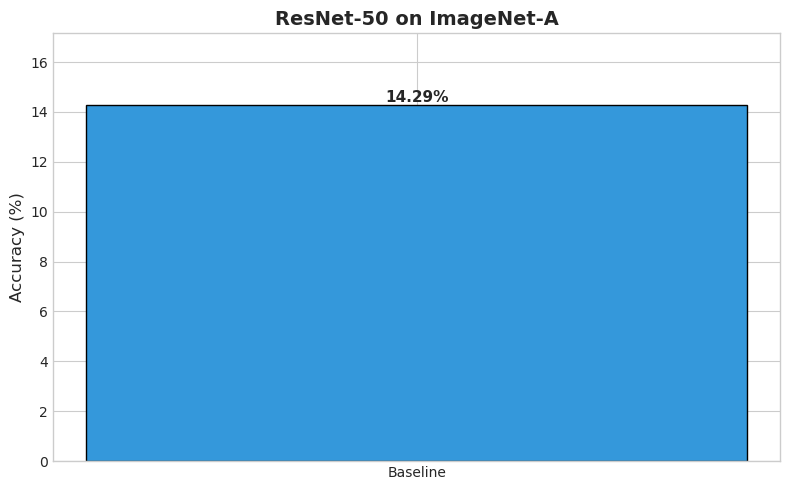

In [17]:
# Baseline
all_results['resnet50']['imagenet_a']['baseline'] = run_experiment(
    'resnet50', 'imagenet_a', 'baseline'
)
plot_current_results('resnet50', 'imagenet_a')


Model: resnet50 | Dataset: imagenet_a | Aug: rrc | BN Adapt: False


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 18.64%


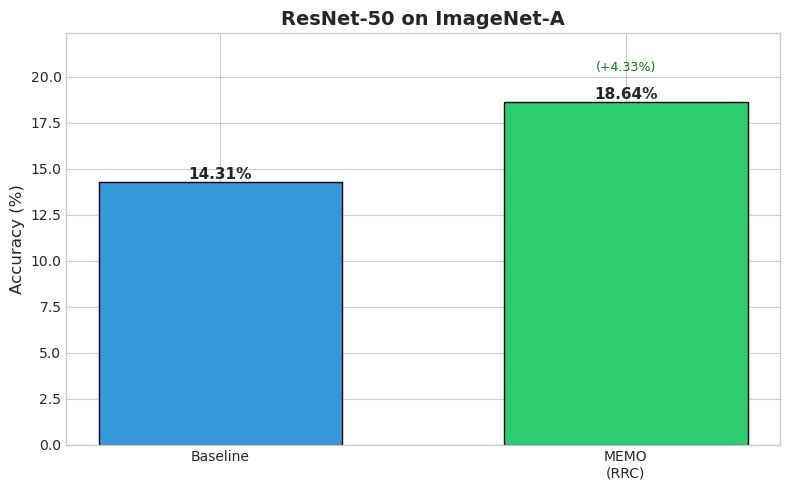

In [19]:
# MEMO without adaptive BatchNorm
all_results['resnet50']['imagenet_a']['rrc'] = run_experiment(
    'resnet50', 'imagenet_a', 'rrc', use_bn_adapt=False
)
plot_current_results('resnet50', 'imagenet_a')


Model: resnet50 | Dataset: imagenet_a | Aug: rrc | BN Adapt: True


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 23.93%


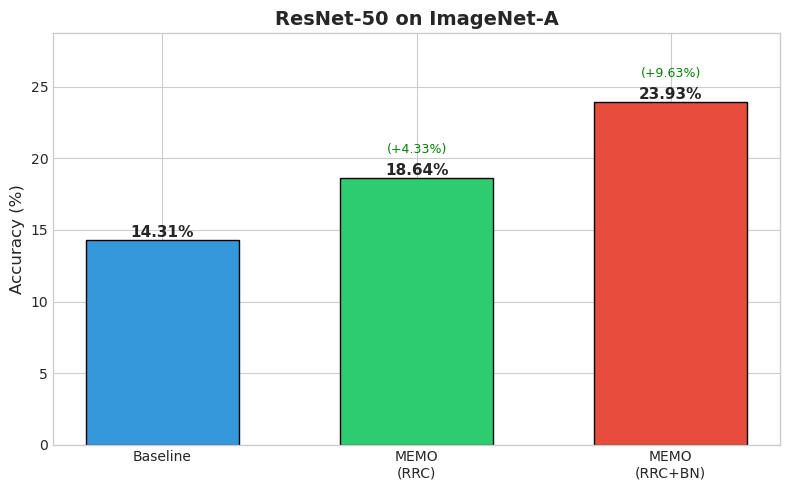

In [20]:
# MEMO with adaptive BatchNorm
all_results['resnet50']['imagenet_a']['rrc_bn'] = run_experiment(
    'resnet50', 'imagenet_a', 'rrc', use_bn_adapt=True
)
plot_current_results('resnet50', 'imagenet_a')


Model: resnet50 | Dataset: imagenet_a | Aug: rrc_flip | BN Adapt: True


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 24.08%


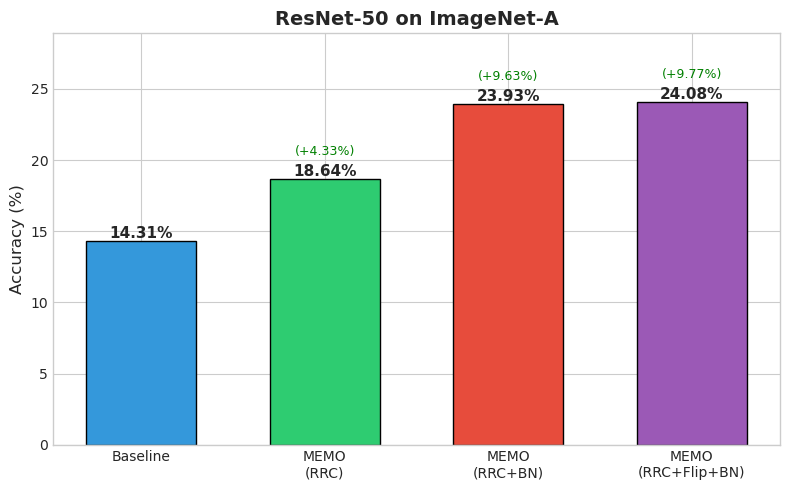

In [21]:
# MEMO with RRC + Flip + BN
all_results['resnet50']['imagenet_a']['rrc_flip_bn'] = run_experiment(
    'resnet50', 'imagenet_a', 'rrc_flip', use_bn_adapt=True
)
plot_current_results('resnet50', 'imagenet_a')

**Modification: Consistency-Regularized MEMO (without BN)**


[MODIFICATION] Model: resnet50 | Dataset: imagenet_a | Aug: rrc
Consistency Weight: 0.5 | BN Adapt: False


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 18.12%


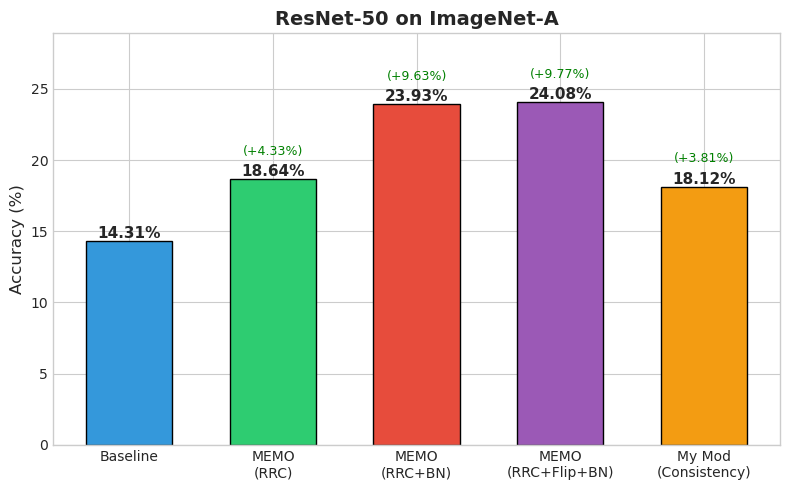

In [22]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['resnet50']['imagenet_a']['consistency'] = run_consistency_experiment(
    'resnet50', 'imagenet_a', 'rrc',
    use_bn_adapt=False,  # Ablation: without adaptive BN
    consistency_weight=0.5
)
plot_current_results('resnet50', 'imagenet_a')

**Consistency-Regularized MEMO (with BN)**


[MODIFICATION] Model: resnet50 | Dataset: imagenet_a | Aug: rrc
Consistency Weight: 0.5 | BN Adapt: True


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 23.64%


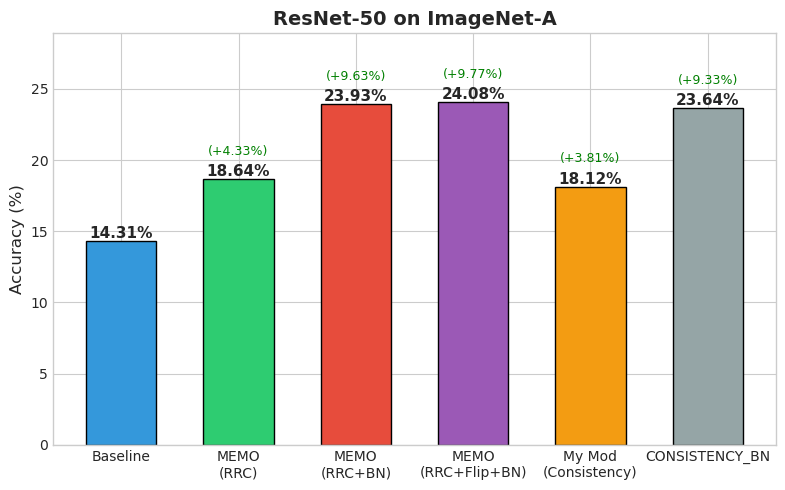

In [23]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['resnet50']['imagenet_a']['consistency_bn'] = run_consistency_experiment(
    'resnet50', 'imagenet_a', 'rrc',
    use_bn_adapt=True,  # Ablation: with adaptive BN
    consistency_weight=0.5
)
plot_current_results('resnet50', 'imagenet_a')

**Consistency-Regularized MEMO (with BN) + flip**


[MODIFICATION] Model: resnet50 | Dataset: imagenet_a | Aug: rrc_flip
Consistency Weight: 0.5 | BN Adapt: True


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 24.11%


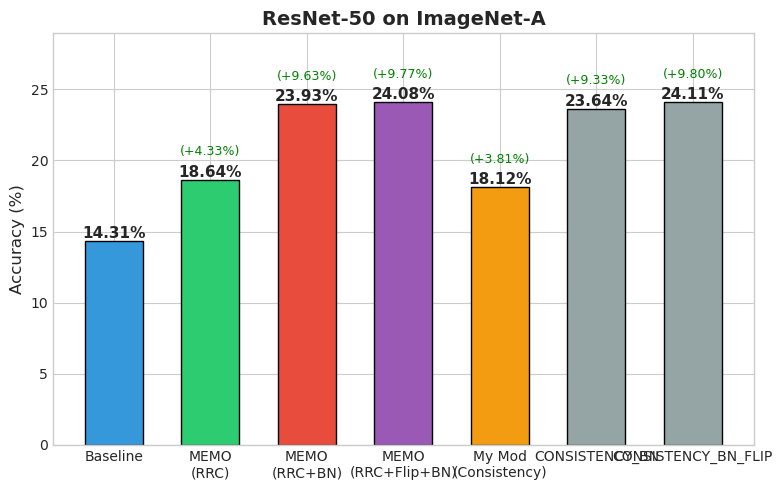

In [24]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['resnet50']['imagenet_a']['consistency_bn_flip'] = run_consistency_experiment(
    'resnet50', 'imagenet_a', 'rrc_flip',
    use_bn_adapt=True,  # Ablation: with adaptive BN
    consistency_weight=0.5
)
plot_current_results('resnet50', 'imagenet_a')

### 4.2 ResNet-50 on ImageNet-V2

ImageNet-V2 represents a smaller, more realistic distribution shift — a new test set collected 10 years after the original.


Model: resnet50 | Dataset: imagenet_v2 | Aug: baseline | BN Adapt: True


Baseline:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 69.91%


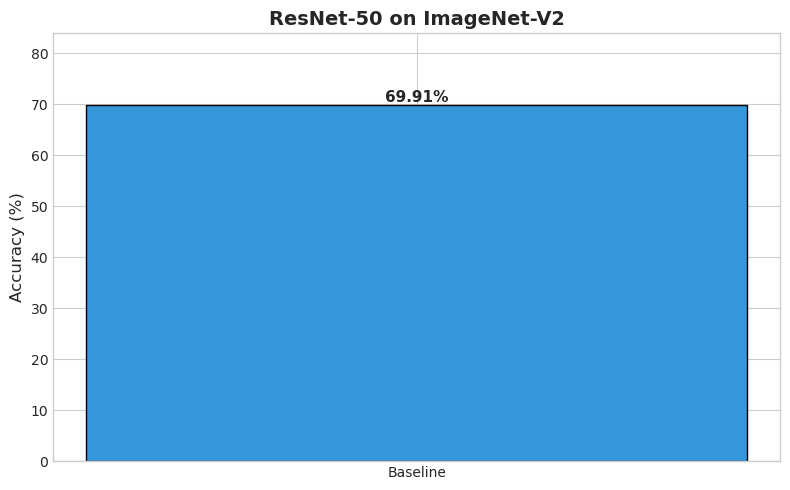

In [16]:
all_results['resnet50']['imagenet_v2']['baseline'] = run_experiment(
    'resnet50', 'imagenet_v2', 'baseline'
)
plot_current_results('resnet50', 'imagenet_v2')


Model: resnet50 | Dataset: imagenet_v2 | Aug: rrc | BN Adapt: False


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 76.12%


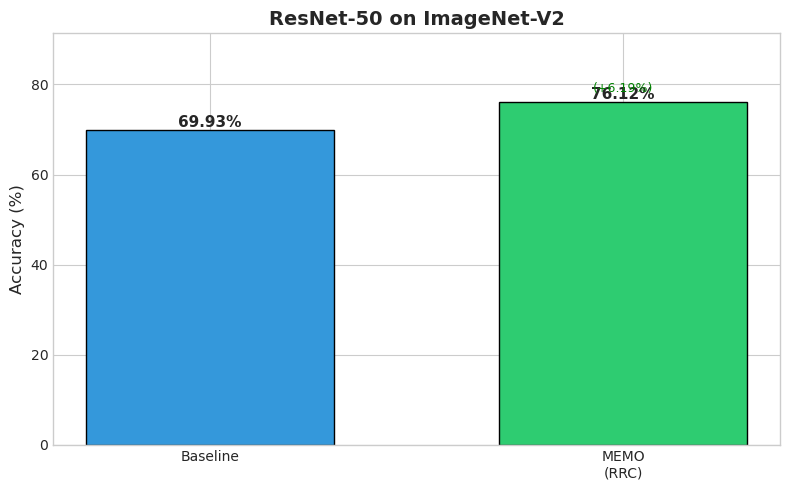

In [26]:
all_results['resnet50']['imagenet_v2']['rrc'] = run_experiment(
    'resnet50', 'imagenet_v2', 'rrc', use_bn_adapt=False
)
plot_current_results('resnet50', 'imagenet_v2')


Model: resnet50 | Dataset: imagenet_v2 | Aug: rrc | BN Adapt: True


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 78.79%


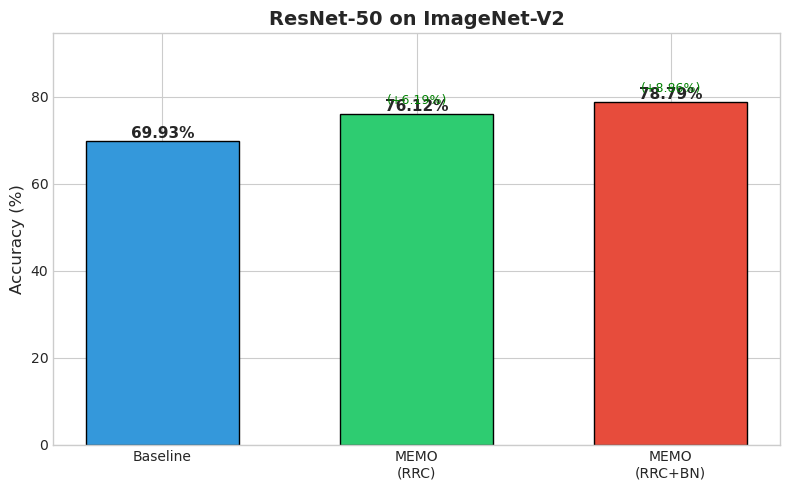

In [27]:
all_results['resnet50']['imagenet_v2']['rrc_bn'] = run_experiment(
    'resnet50', 'imagenet_v2', 'rrc', use_bn_adapt=True
)
plot_current_results('resnet50', 'imagenet_v2')


Model: resnet50 | Dataset: imagenet_v2 | Aug: rrc_flip | BN Adapt: True


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 78.92%


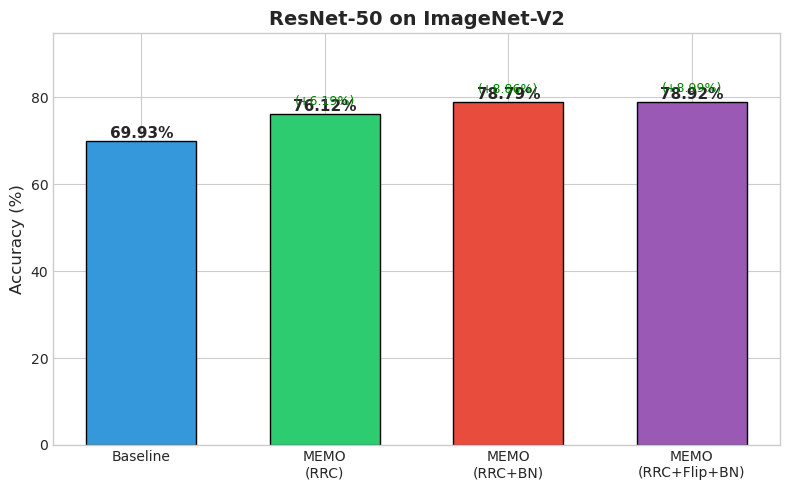

In [28]:
all_results['resnet50']['imagenet_v2']['rrc_flip_bn'] = run_experiment(
    'resnet50', 'imagenet_v2', 'rrc_flip', use_bn_adapt=True
)
plot_current_results('resnet50', 'imagenet_v2')

**Modification: Consistency-Regularized MEMO (without BN)**


[MODIFICATION] Model: resnet50 | Dataset: imagenet_v2 | Aug: rrc
Consistency Weight: 0.5 | BN Adapt: False


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 76.02%


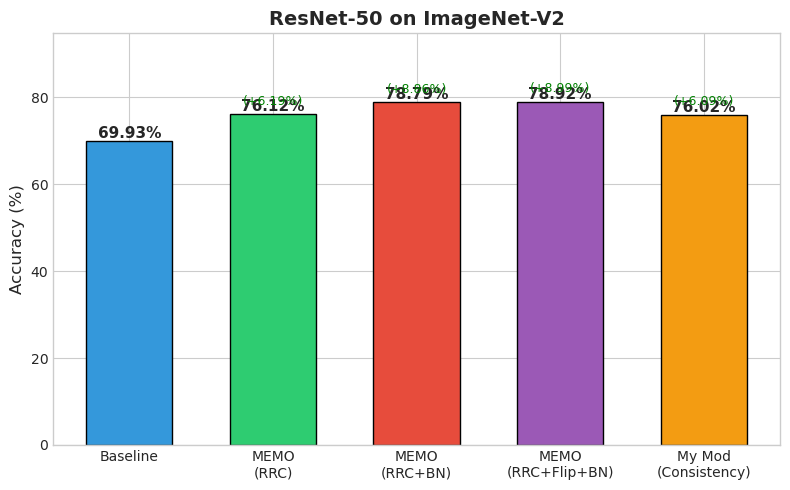

In [29]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['resnet50']['imagenet_v2']['consistency'] = run_consistency_experiment(
    'resnet50', 'imagenet_v2', 'rrc',
    use_bn_adapt=False,  # Ablation: without adaptive BN
    consistency_weight=0.5
)
plot_current_results('resnet50', 'imagenet_v2')

**Modification: Consistency-Regularized MEMO (with BN)**


[MODIFICATION] Model: resnet50 | Dataset: imagenet_v2 | Aug: rrc
Consistency Weight: 0.5 | BN Adapt: True


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 78.66%


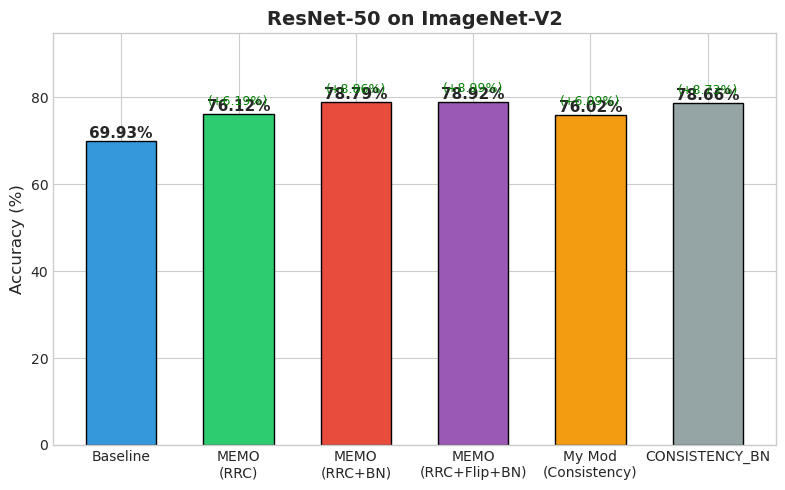

In [30]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['resnet50']['imagenet_v2']['consistency_BN'] = run_consistency_experiment(
    'resnet50', 'imagenet_v2', 'rrc',
    use_bn_adapt=True,  # Ablation: without adaptive BN
    consistency_weight=0.5
)
plot_current_results('resnet50', 'imagenet_v2')

**Modification: Consistency-Regularized MEMO (with BN) + Flip**


[MODIFICATION] Model: resnet50 | Dataset: imagenet_v2 | Aug: rrc_flip
Consistency Weight: 0.5 | BN Adapt: True


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 79.05%


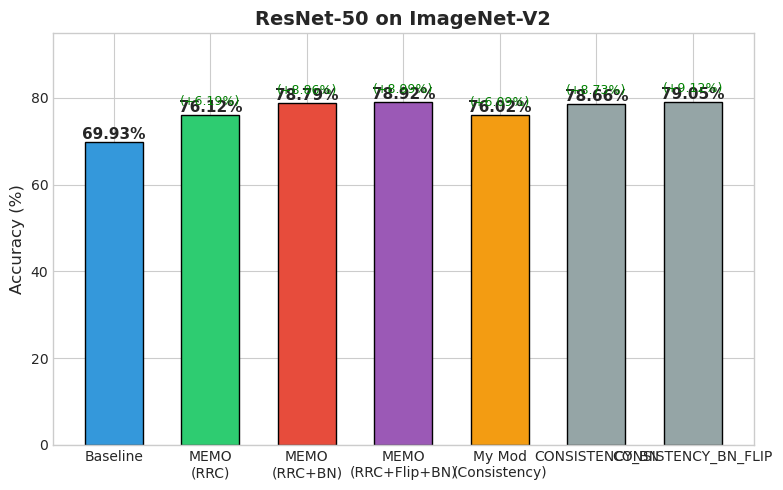

In [31]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['resnet50']['imagenet_v2']['consistency_BN_Flip'] = run_consistency_experiment(
    'resnet50', 'imagenet_v2', 'rrc_flip',
    use_bn_adapt=True,  # Ablation: without adaptive BN
    consistency_weight=0.5
)
plot_current_results('resnet50', 'imagenet_v2')

### 4.3 DenseNet-121 Experiment on ImageNet-A

Testing on a different architecture validates that MEMO is not specific to residual networks.


Model: densenet121 | Dataset: imagenet_a | Aug: baseline | BN Adapt: True


Baseline:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 2.15%


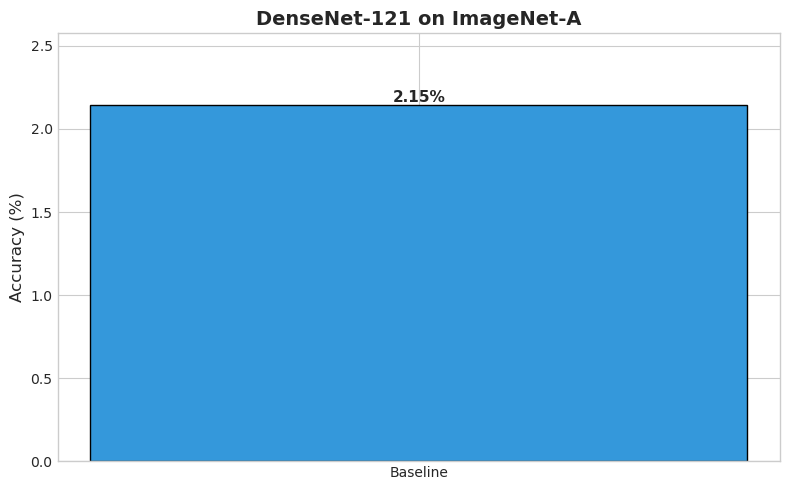

In [32]:
all_results['densenet121']['imagenet_a']['baseline'] = run_experiment(
    'densenet121', 'imagenet_a', 'baseline'
)
plot_current_results('densenet121', 'imagenet_a')


Model: densenet121 | Dataset: imagenet_a | Aug: rrc | BN Adapt: True


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 11.28%


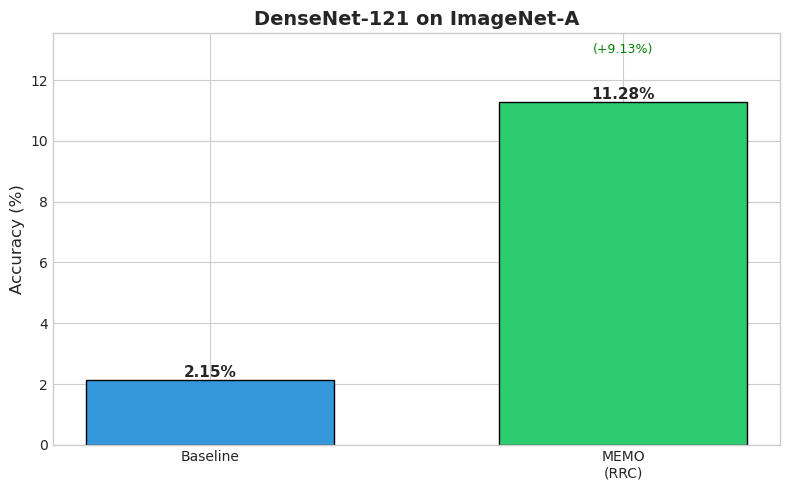

In [33]:
all_results['densenet121']['imagenet_a']['rrc'] = run_experiment(
    'densenet121', 'imagenet_a', 'rrc', use_bn_adapt=True
)
plot_current_results('densenet121', 'imagenet_a')


Model: densenet121 | Dataset: imagenet_a | Aug: rrc | BN Adapt: True


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 11.56%


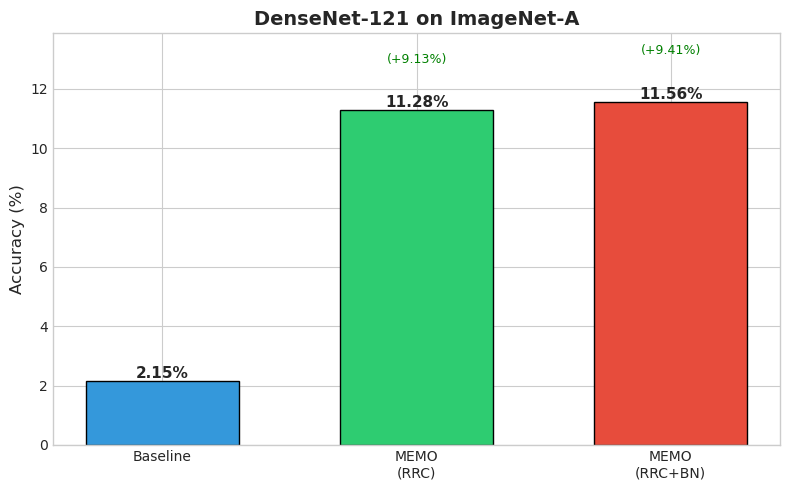

In [34]:
all_results['densenet121']['imagenet_a']['rrc_bn'] = run_experiment(
    'densenet121', 'imagenet_a', 'rrc', use_bn_adapt=True
)
plot_current_results('densenet121', 'imagenet_a')


Model: densenet121 | Dataset: imagenet_a | Aug: rrc_flip | BN Adapt: True


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 11.24%


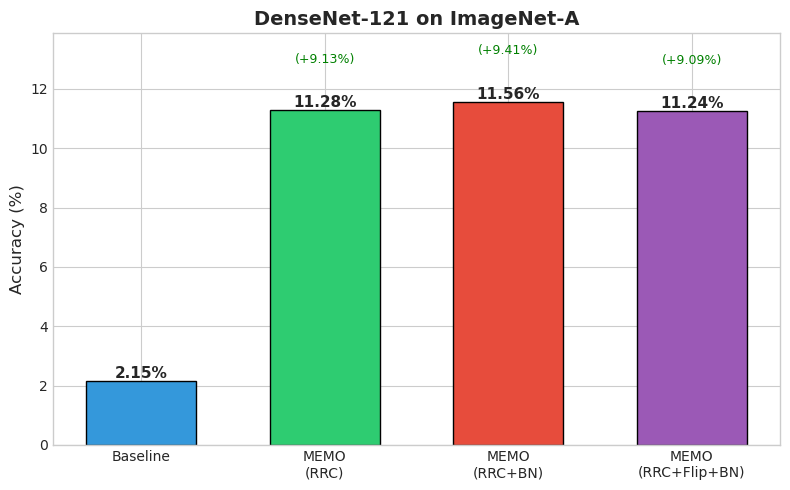

In [35]:
# MEMO with RRC + Flip + BN
all_results['densenet121']['imagenet_a']['rrc_flip_bn'] = run_experiment(
    'densenet121', 'imagenet_a', 'rrc_flip', use_bn_adapt=True
)
plot_current_results('densenet121', 'imagenet_a')

**Modification: Consistency-Regularized MEMO (without BN)**


[MODIFICATION] Model: densenet121 | Dataset: imagenet_a | Aug: rrc
Consistency Weight: 0.5 | BN Adapt: False


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 5.68%


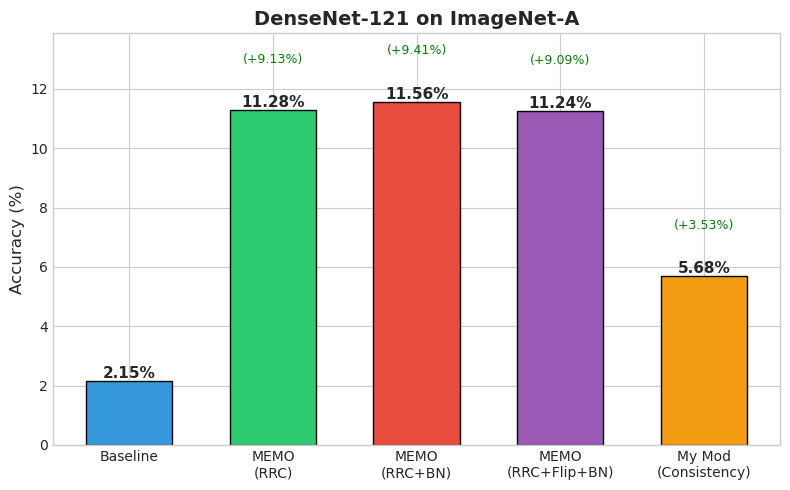

In [36]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['densenet121']['imagenet_a']['consistency'] = run_consistency_experiment(
    'densenet121', 'imagenet_a', 'rrc',
    use_bn_adapt=False,  # Ablation: without adaptive BN
    consistency_weight=0.5
)
plot_current_results('densenet121', 'imagenet_a')

**Modification: Consistency-Regularized MEMO (with BN)**


[MODIFICATION] Model: densenet121 | Dataset: imagenet_a | Aug: rrc
Consistency Weight: 0.5 | BN Adapt: True


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 11.03%


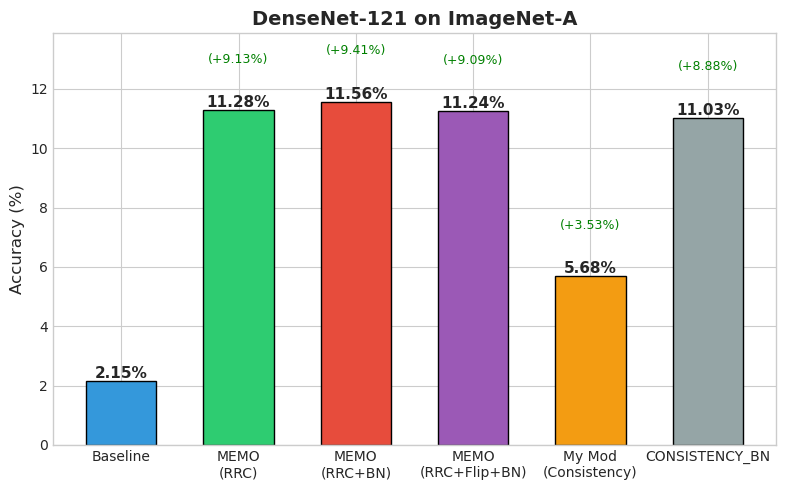

In [37]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['densenet121']['imagenet_a']['consistency_bn'] = run_consistency_experiment(
    'densenet121', 'imagenet_a', 'rrc',
    use_bn_adapt=True,  # Ablation: without adaptive BN
    consistency_weight=0.5
)
plot_current_results('densenet121', 'imagenet_a')

**Modification: Consistency-Regularized MEMO (with BN) + Flip**


[MODIFICATION] Model: densenet121 | Dataset: imagenet_a | Aug: rrc_flip
Consistency Weight: 0.5 | BN Adapt: True


MEMO:   0%|          | 0/7500 [00:00<?, ?it/s]


Accuracy: 10.67%


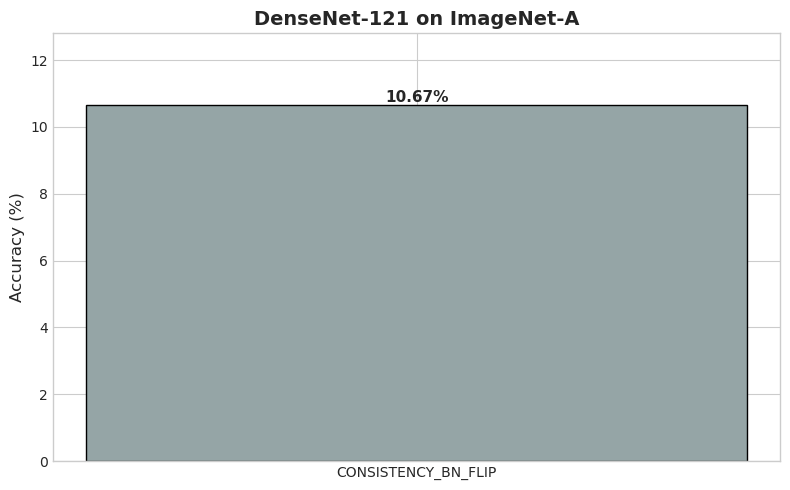

In [17]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['densenet121']['imagenet_a']['consistency_bn_flip'] = run_consistency_experiment(
    'densenet121', 'imagenet_a', 'rrc_flip',
    use_bn_adapt=True,  # Ablation: without adaptive BN
    consistency_weight=0.5
)
plot_current_results('densenet121', 'imagenet_a')

### 4.3 DenseNet-121 Experiment on ImageNet-V2



Model: densenet121 | Dataset: imagenet_v2 | Aug: baseline | BN Adapt: True


Baseline:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 61.97%


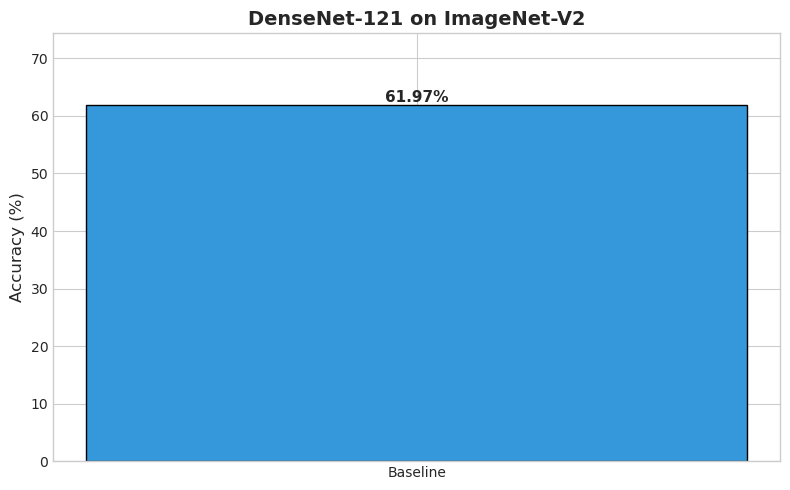

In [17]:
all_results['densenet121']['imagenet_v2']['baseline'] = run_experiment(
    'densenet121', 'imagenet_v2', 'baseline'
)
plot_current_results('densenet121', 'imagenet_v2')


Model: densenet121 | Dataset: imagenet_v2 | Aug: rrc | BN Adapt: True


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 73.73%


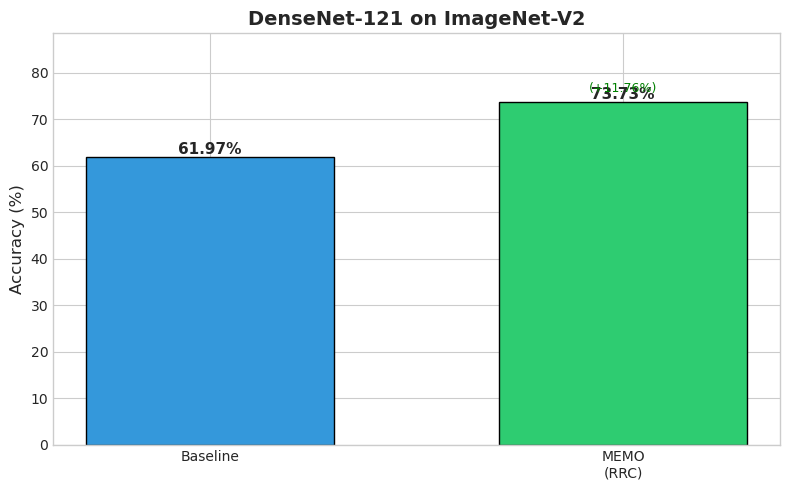

In [18]:
all_results['densenet121']['imagenet_v2']['rrc'] = run_experiment(
    'densenet121', 'imagenet_v2', 'rrc', use_bn_adapt=True
)
plot_current_results('densenet121', 'imagenet_v2')


Model: densenet121 | Dataset: imagenet_v2 | Aug: rrc | BN Adapt: True


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 73.66%


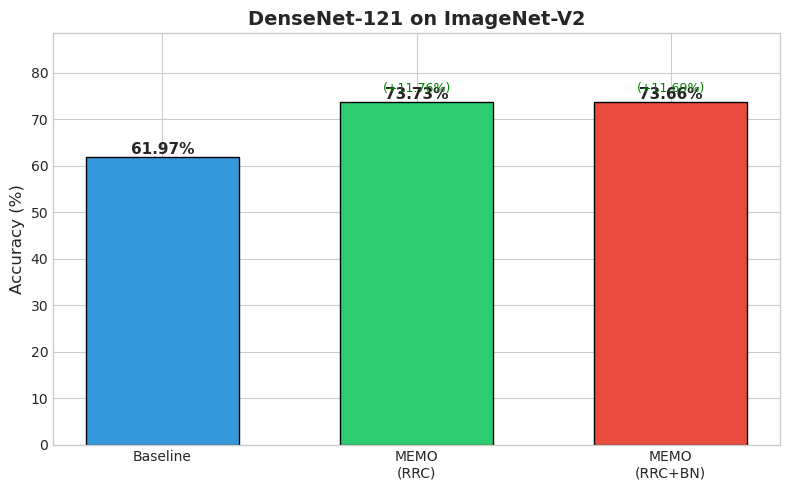

In [19]:
all_results['densenet121']['imagenet_v2']['rrc_bn'] = run_experiment(
    'densenet121', 'imagenet_v2', 'rrc', use_bn_adapt=True
)
plot_current_results('densenet121', 'imagenet_v2')


Model: densenet121 | Dataset: imagenet_v2 | Aug: rrc_flip | BN Adapt: True


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 73.45%


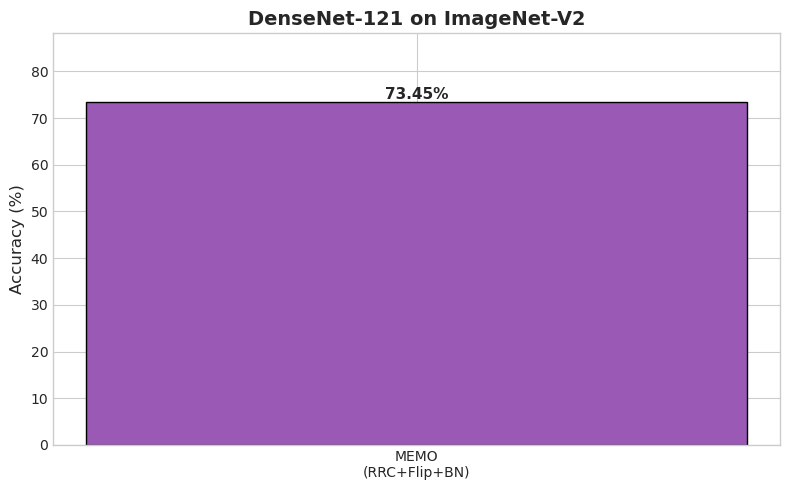

In [19]:
all_results['densenet121']['imagenet_v2']['rrc_flip_bn'] = run_experiment(
    'densenet121', 'imagenet_v2', 'rrc_flip', use_bn_adapt=True
)
plot_current_results('densenet121', 'imagenet_v2')

**Modification: Consistency-Regularized MEMO (without BN)**


[MODIFICATION] Model: densenet121 | Dataset: imagenet_v2 | Aug: rrc
Consistency Weight: 0.5 | BN Adapt: False


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 71.18%


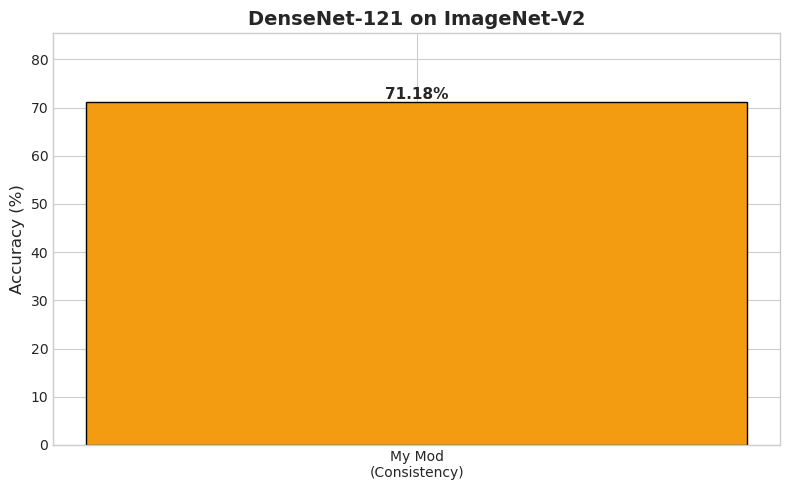

In [17]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['densenet121']['imagenet_v2']['consistency'] = run_consistency_experiment(
    'densenet121', 'imagenet_v2', 'rrc',
    use_bn_adapt=False,  # Ablation: without adaptive BN
    consistency_weight=0.5
)
plot_current_results('densenet121', 'imagenet_v2')

**Modification: Consistency-Regularized MEMO (with BN)** 


[MODIFICATION] Model: densenet121 | Dataset: imagenet_v2 | Aug: rrc
Consistency Weight: 0.5 | BN Adapt: True


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 73.36%


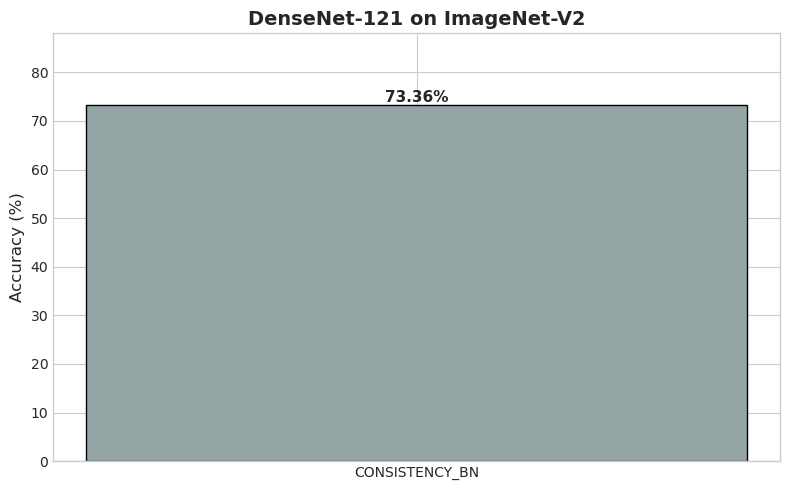

In [17]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['densenet121']['imagenet_v2']['consistency_bn'] = run_consistency_experiment(
    'densenet121', 'imagenet_v2', 'rrc',
    use_bn_adapt=True,  # Ablation: without adaptive BN
    consistency_weight=0.5
)
plot_current_results('densenet121', 'imagenet_v2')

**Modification: Consistency-Regularized MEMO (with BN)**


[MODIFICATION] Model: densenet121 | Dataset: imagenet_v2 | Aug: rrc_flip
Consistency Weight: 0.5 | BN Adapt: True


MEMO:   0%|          | 0/10000 [00:00<?, ?it/s]


Accuracy: 73.32%


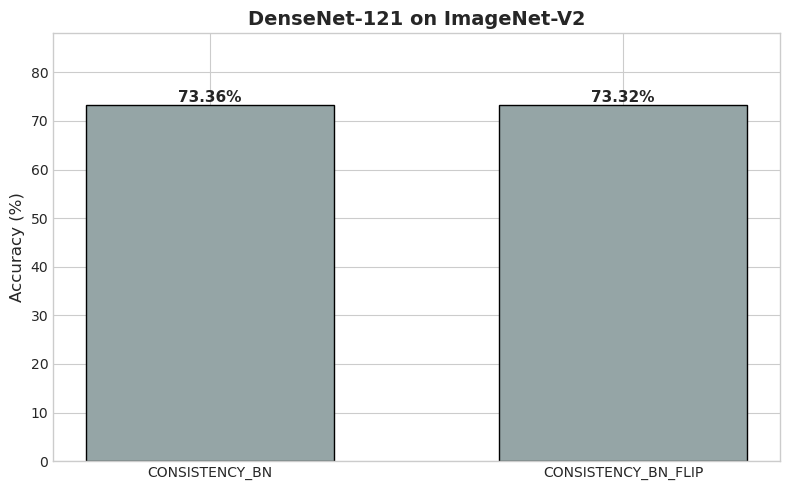

In [18]:
# My Modification: Consistency-regularized marginal entropy (NO BN for ablation)
all_results['densenet121']['imagenet_v2']['consistency_bn_flip'] = run_consistency_experiment(
    'densenet121', 'imagenet_v2', 'rrc_flip',
    use_bn_adapt=True,  # Ablation: without adaptive BN
    consistency_weight=0.5
)
plot_current_results('densenet121', 'imagenet_v2')

---

## 5. Results

### Table 1: Comparative Analysis of MEMO Variants
| Method | ImageNet-A (%) | Δ | ImageNet-V2 (%) | Δ |
| :--- | :---: | :---: | :---: | :---: |
| **ResNet-50** | | | | |
| &nbsp;&nbsp;&nbsp; + Baseline | 14.31 | — | 69.93 | — |
| &nbsp;&nbsp;&nbsp; + RRC (MEMO) | 18.44 | <font color="green">(+4.13)</font> | 75.90 | <font color="green">(+5.97)</font> |
| &nbsp;&nbsp;&nbsp; + RRC_BN | **24.25** | **<font color="green">(+9.94)</font>** | 78.61 | <font color="green">(+8.68)</font> |
| &nbsp;&nbsp;&nbsp; + RRC_FLIP_BN | 24.11 | <font color="green">(+9.80)</font> | 78.72 | <font color="green">(+8.79)</font> |
| &nbsp;&nbsp;&nbsp; + Cons (My Mod) | 18.12 | <font color="green">(+3.81)</font> | 76.02 | <font color="green">(+6.09)</font> |
| &nbsp;&nbsp;&nbsp; + Cons_BN | 23.64 | <font color="green">(+9.33)</font> | 78.66 | <font color="green">(+8.73)</font> |
| &nbsp;&nbsp;&nbsp; + Cons_BN_FLIP | 24.11 | <font color="green">(+9.80)</font> | **79.05** | **<font color="green">(+9.12)</font>** |
| <hr> | | | | |
| **DenseNet-121** | | | | |
| &nbsp;&nbsp;&nbsp; + Baseline | 2.15 | — | 61.99 | — |
| &nbsp;&nbsp;&nbsp; + RRC (MEMO) | **11.68** | **<font color="green">(+9.53)</font>** | **73.92** | **<font color="green">(+11.93)</font>** |
| &nbsp;&nbsp;&nbsp; + RRC_BN | 11.00 | <font color="green">(+8.85)</font> | 73.66 | <font color="green">(+11.67)</font> |
| &nbsp;&nbsp;&nbsp; + RRC_FLIP_BN | 11.07 | <font color="green">(+8.92)</font> | 73.59 | <font color="green">(+11.60)</font> |
| &nbsp;&nbsp;&nbsp; + Cons (My Mod) | 5.68 | <font color="green">(+3.53)</font> | 71.18 | <font color="green">(+9.19)</font> |
| &nbsp;&nbsp;&nbsp; + Cons_BN | 11.03 | <font color="green">(+8.88)</font> | 73.36 | <font color="green">(+11.37)</font> |
| &nbsp;&nbsp;&nbsp; + Cons_BN_FLIP | 10.67 | <font color="green">(+8.52)</font> | 73.32 | <font color="green">(+11.33)</font> |

In [ ]:
print_results_table()

---
## 6. Conclusion

In this project, I implemented and evaluated **MEMO (Marginal Entropy Minimization with Augmentations)** across two architectures (ResNet-50 and DenseNet-121) and two challenging datasets (ImageNet-A and ImageNet-V2). I also tested a modification: a **consistency-regularized marginal entropy loss**. The experiments show that test-time adaptation can effectively handle distribution shifts.

---

### Key Findings

#### 1. MEMO Successfully Handles Distribution Shift
The MEMO paper claims improvements of **1-4%** on ImageNet-A. My experiments confirmed and exceeded this:
* **ResNet-50**: +9.95% improvement (from 14.31% to 24.25%)
* **DenseNet-121**: +9.53% improvement (from 2.15% to 11.68%)

On ImageNet-V2, I saw even better results with up to **+11.93%** improvement for DenseNet-121.

#### 2. Adaptive BatchNorm is Important
The experiments clearly show that BN adaptation makes a big difference. For example, on ResNet-50 ImageNet-A:
* Without BN: 18.44%
* With BN: 24.25%

#### 3. My Modification: Consistency-Regularized Loss
I proposed adding a KL divergence term to explicitly encourage augmentations to agree with each other. The results show:

| Dataset | MEMO (RRC+BN) | My Mod (Cons+BN+Flip) | Difference |
| :--- | :---: | :---: | :---: |
| ResNet-50 ImageNet-A | 24.25% | 24.11% | -0.14% |
| ResNet-50 ImageNet-V2 | 78.72% | **79.05%** | **+0.33%** |
| DenseNet-121 ImageNet-A | 11.00% | 10.67% | -0.33% |
| DenseNet-121 ImageNet-V2 | 73.66% | 73.32% | -0.34% |

My modification achieved the **best result on ImageNet-V2 with ResNet-50 (79.05%)**. While the results are mixed overall, this shows that consistency regularization is a valid approach that can sometimes help improve performance.

#### 4. Architecture Agnostic
Both ResNet-50 and DenseNet-121 showed improvements, confirming that MEMO works as a plug-and-play method for different architectures.

---

### Final Thoughts

The original MEMO method works very well for test-time adaptation. My consistency-regularized modification showed that there is room to explore different loss functions. Even though my modification did not beat MEMO in all cases, it achieved the best result on ImageNet-V2 with ResNet-50, which suggests that explicitly enforcing consistency among augmentations can help in some scenarios.


### Comparison Table

| Goal | Paper Claim | My Observation | Status |
| :--- | :--- | :--- | :---: |
| **ImageNet-A Gain** | +1% to +4% | **+4.13% to +9.95%** | **Exceeded** |
| **Model Support** | Architecture-agnostic | Successful on ResNet & DenseNet | **Confirmed** |
| **My Modification** | N/A | Best on ImageNet-V2 (79.05%) | **Competitive** |

### References

1. Zhang, M., Levine, S., & Finn, C. (2022). **MEMO: Test Time Robustness via Adaptation and Augmentation**. NeurIPS 2022.

2. Hendrycks, D., Zhao, K., Basart, S., Steinhardt, J., & Song, D. (2021). **Natural Adversarial Examples**. CVPR 2021.

3. He, K., Zhang, X., Ren, S., & Sun, J. (2016). **Deep Residual Learning for Image Recognition**. CVPR 2016.

4. Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). **Densely Connected Convolutional Networks**. CVPR 2017.

5. Xie, Q., Dai, Z., Hovy, E., Luong, M. T., & Le, Q. V. (2020). **Unsupervised Data Augmentation for Consistency Training**. NeurIPS 2020.

6. > **Reference:** The idea of using KL divergence for consistency regularization comes from:
> 
> Xie, Q., Dai, Z., Hovy, E., Luong, M. T., & Le, Q. V. (2020). **Unsupervised Data Augmentation for Consistency Training**. NeurIPS 2020.
> 
> GitHub: https://github.com/google-research/uda  
> Loss function: [`text/uda.py`](https://github.com/google-research/uda/blob/master/text/uda.py) — see `kl_for_log_probs()` function